In [0]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import math
import pickle

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torch import nn as nn
from torch.optim import lr_scheduler
import copy
import time
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, classification_report, balanced_accuracy_score

from sklearn.decomposition import PCA

import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load and transform data to tensor

In [2]:
seed=622
np.random.seed(seed)
torch.manual_seed(seed)

In [96]:
colab_env = True

if not(colab_env):
    validation = pd.read_hdf('preprocessed.h5', 'validation')
    X_resampled, y_resampled = pickle.load(open( "resampled", "rb" ))
    
else:
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    validation = pd.read_hdf('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'validation')
    test = pd.read_hdf('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'test')
#     X_resampled, y_resampled = pickle.load(open( "/content/gdrive/My Drive/Colab Notebooks/we_data/resampled", "rb" ))
#     X_subsampled, y_subsampled = pickle.load(open( "/content/gdrive/My Drive/Colab Notebooks/we_data/subsampled", "rb" ))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
X_validation = validation.drop(columns=['click', 'payprice']).values
y_validation = validation['click'].values
input_layer = X_validation.shape[1]
                                              
# weights = torch.DoubleTensor(1-(np.bincount(y_resampled))/len(y_resampled))                                   
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 2) 
# samples = torch.utils.data.BatchSampler(sampler, batch_size=1000, drop_last=False)

# print(X_resampled.shape[1] == X_validation.shape[1])

# train_loader = TensorDataset(torch.from_numpy(X_resampled).float(), torch.from_numpy(y_resampled).float())
# train_loader = TensorDataset(torch.from_numpy(X_subsampled.values).float(), torch.from_numpy(y_subsampled).float())

# train_loader = DataLoader(train_loader, num_workers=4, batch_size=50000, shuffle=True)

validation_loader = TensorDataset(torch.from_numpy(X_validation).float(), torch.from_numpy(y_validation).float())
validation_loader = DataLoader(validation_loader, batch_size=40000, shuffle=True, num_workers=4)

#  free up memory
del(X_validation, y_validation, validation)

# Define model

In [0]:
# set seed fucntiosn
seed=622
np.random.seed(seed)
torch.manual_seed(seed)

# set number of nodes per hidden layer
hidden_layer_1 = 2**11
hidden_layer_2 = 2**11
hidden_layer_3 = 2**11
hidden_layer_4 = 2**11
output_layer = 1

# add linear layers and init weight function
linear1 = nn.Linear(input_layer, hidden_layer_1)
nn.init.xavier_uniform_(linear1.weight)

linear2 = nn.Linear(hidden_layer_1, hidden_layer_2)
nn.init.xavier_uniform_(linear2.weight)

linear3 = nn.Linear(hidden_layer_2, hidden_layer_3)
nn.init.xavier_uniform_(linear3.weight)

linear4 = nn.Linear(hidden_layer_3, hidden_layer_4)
nn.init.xavier_uniform_(linear4.weight)

output = nn.Linear(hidden_layer_4, output_layer)
nn.init.xavier_uniform_(output.weight)

# dropout nodes when training the model to prevent over fitting
dropout = nn.Dropout(p=0.5)

# set sequential NN model
model = torch.nn.Sequential(
    linear1,
    dropout,
    nn.PReLU(),
    linear2,
    dropout,
    nn.PReLU(),
    linear3,
    dropout,
    nn.PReLU(),
    linear4,
    dropout,
    nn.ReLU(),
    output,
    nn.Sigmoid()
)

# enable parallel processing
model = nn.DataParallel(model)

# set loss fuction
criterion = nn.BCELoss()

# set optimiser function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every step_size
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


# Utilise GPU when avalible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# check if this is redundeant when the above is given
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print('Running on {}'.format(device))

print(model)

# Train function

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    print('Running on {}\n'.format(device))
    
    # keep track of historical ROC AUC scores
    rocauc_history = []
    
    # keep track of time spend
    since = time.time()
    
    # init current best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # best perforamce metrics
    best_roc = 0.0
    best_acc = 0.0
    model_loss = None
    
    num_updates = 0
    
    # loop through number of epochs
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # each epoch contains of a train and valdiation phase 
        # where validation is done on validation set
        for phase in ['train', 'val']:

            # Set NN to training
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                loader = train_loader
                loader_len = len(loader.dataset)

            # Set NN to evaluate
            else:
                model.eval()
                loader = validation_loader
                loader_len = len(loader.dataset)
            
            # scores of current phase and epoch
            running_loss = 0.0
            running_roc = 0.0
            running_acc = 0.0
            running_len = 0
            
            # loop trough minibatches
            for batch, (data, target) in enumerate(loader):
                data, target = Variable(data), Variable(target)

                data = data.to(device)
                target = target.to(device)

                # Reset gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    # Forward Propagation
                    output = model(data)

                    # loss function
                    loss = criterion(output.squeeze(), target)

                    prediction = (output.data).float()
                    y_hat_prob = prediction.cpu().numpy().squeeze()
                    
                    y_hat_class = (prediction.cpu() > 0.5).float()

                    target_y = target.cpu().data.numpy()

                    # get predicted labels
                    _, preds = torch.max(output, 1)

                    # optimise in training
                    if phase == 'train':

                        # Backwards propagation error
                        loss.backward()

                        # apply
                        optimizer.step()
                        
                        
                # statistics
                running_loss += loss.item() * data.size(0)

                # only update the ROC AUC when there are two classes present in the target class
                # pick a batch size in such a way this doesn't happen too frequent, very occasinal is unavoidable
                # note I have tried weighted batch sampling but seems to have very little effect
                if(max(target_y) == 1):
                    running_roc += roc_auc_score(target_y,
                                             y_hat_prob) * data.size(0)
                    running_acc += balanced_accuracy_score(
                        target_y, y_hat_class) * data.size(0)
                    running_len += data.size(0)
                    
                else:
                    print('skip calculation ROC')

                if (batch + 1) % 50 == 0:
                    print('{} Epoch: {} [{}/{} ({:.0f}%)]'.format(
                        phase, epoch, (batch + 1) * len(data),
                        len(loader.dataset), 100. * (batch + 1) / len(loader)))
            
            # update epoch scores
            epoch_loss = running_loss / loader_len
            epoch_roc = running_roc / running_len
            epoch_acc = running_acc / running_len

            print(
                '\n\t{}:\tLoss {:.5f},\tROC AUC {:.5f},\tBalanced Acc {:.5f}'.
                format(phase, epoch_loss, epoch_roc, epoch_acc))

            if (phase == 'val'):

                # keep track of ROC AUC development
                rocauc_history.append(epoch_roc)

                if (model_loss == None):
                    model_loss = epoch_loss

                # deep copy the model
                if epoch_roc >= best_roc:
                    print('\t\tsave updated model')
                    best_roc = epoch_roc
                    model_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    num_updates += 1

    print('\n')
    print('=' * 30)
    print('=' * 30)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    print(
        'Model Loss:\t{:4f}\nROC AUC:\t{:4f}\nAccuracy:\t{:4f}\nModel updates:\t{}'
        .format(model_loss, best_roc, best_acc, num_updates))

    filename = 'model_roc_{:.3f}_balanced_acc_{:.3f}_model_loss_{:.3f}.pt'.format(
        best_roc, best_acc, model_loss)

    # load best model weights and return this model
    model.load_state_dict(best_model_wts)
    
    return model, filename, rocauc_history

In [0]:
# train model
best_model, filename, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)

# save model to drive
file_poiter = '/content/gdrive/My Drive/Colab Notebooks/' + filename
torch.save(best_model, file_poiter)

# diagnostic plot
plt.plot(history)
plt.title('ROC AUC evaluation over time')
plt.ylabel('ROC AUC')
sns.despine()
plt.show()

## Train on entire train dataset

In [0]:
store = pd.HDFStore('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'r')
rows = store.get_storer('train').shape[0]

# split into 8 chunks
chunks = np.array_split(np.arange(0,rows), 8)

i = 0
for chunk in chunks:
    print('\n\n')
    print('/'*100)
    print('chunk {}'.format(i))
    print('/'*100)
    print('')
    start = chunk[0]
    stop = chunk[-1]
    del(chunk)

    sub_frame = store.select('train',start=start,stop=stop)
    
    X_train_chunk = sub_frame.drop(columns=['click', 'payprice']).values
    y_train_chunk = sub_frame['click'].values
    
    
    train_loader = TensorDataset(torch.from_numpy(X_train_chunk).float(), torch.from_numpy(y_train_chunk).float())
    train_loader = DataLoader(train_loader, num_workers=20, batch_size=20000, shuffle=True)
    
    model, filename, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)
    
    file_poiter = '/content/gdrive/My Drive/Colab Notebooks/' + filename
    torch.save(model, file_poiter)
    
    # free memory
    torch.cuda.empty_cache()
    sub_frame.close()
    del(X_train_chunk, y_train_chunk)
    del(train_loader)
    
    
    i += 1

# Find optimal bidding strategy

In [4]:
# load the best NN
file = 'nmodel_roc_0.851_balanced_acc_0.000_model_loss_0.012.pt'

if colab_env:
    PATH = '/content/gdrive/My Drive/Colab Notebooks/' + file
    model = torch.load(PATH)
else:
    PATH = '/Users/davidvanrooij/Google Drive/Colab Notebooks/' + file
    print(PATH)
    model = torch.load(PATH, map_location='cpu')

model.eval()
print(model)

DataParallel(
  (module): Sequential(
    (0): Linear(in_features=963, out_features=1024, bias=True)
    (1): Dropout(p=0.5)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Dropout(p=0.5)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Dropout(p=0.5)
    (8): PReLU(num_parameters=1)
    (9): Linear(in_features=1024, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [0]:
# use NN to predict pCTR
batches = np.array_split(validation, 200)

pCTR = []
for batch in batches:
    data = batch.drop(columns=['click', 'payprice']).values
    target = batch['click'].values
    
    data = torch.from_numpy(data).float()
    target = torch.from_numpy(target).float()
    
    output = model(data)
    
    prediction = (output.data).float()
    y_hat_prob = prediction.cpu().numpy().squeeze()
    
    pCTR.extend(y_hat_prob)
    
pCTR = np.array(pCTR)

# Linear


In [0]:
%%time

payprice = validation['payprice']
clicks = validation['click']

no_click, click = np.bincount(clicks)
avgCTR = click / (no_click + click)

bid_strategy = lambda base_bid: base_bid * (pCTR / avgCTR)

bid_range = np.arange(11, 12, .1)
statistics = {}

# find optimal base_bid
for base_bid in tqdm(bid_range):
    
    budget_remaining = 6250*1000
    
    statistics[base_bid] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0,
        'lost': 0
    }
    
    # list of bids for all ad requests
    bids = bid_strategy(base_bid)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[base_bid]['too_expensive'] += 1
            
        if(second_highest_bid> bids[i]):
            statistics[base_bid]['lost'] += 1
        
        if(won):
            statistics[base_bid]['impressions'] += 1
            statistics[base_bid]['spend'] += second_highest_bid
            statistics[base_bid]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')


  0%|          | 0/10 [00:00<?, ?it/s]

In [0]:
statistics.sort_values('clicks', ascending=False).head(5)

## ORTB1

In [0]:
%%time
payprice = validation['payprice']
clicks = validation['click']

ortb_strategy = lambda lamda, const, pCTR: np.sqrt(np.multiply((const / lamda), pCTR) + const**2) - const

lamda_range = np.linspace(1e-7, 1e-4, num=100)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

# find optimal paramters
for const, lamda in tqdm(parameter_grid):
    budget_remaining = 6250*1000
    
    index = (const, lamda)
    
    statistics[index] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0
    }
    
    # list of bids for all ad requests
    bids = ortb_strategy(lamda, const, pCTR)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[index]['too_expensive'] += 1
        
        
        if(won):
            statistics[index]['impressions'] += 1
            statistics[index]['spend'] += second_highest_bid
            statistics[index]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
    
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')

In [35]:
statistics.sort_values('clicks', ascending=False).head(5)

,,clicks,impressions,spend,too_expensive,CTR,aCPM,aCPC
90,0.000017,160,111670,6249998,207,0.001433,55.968461,39.062487
80,0.000016,160,112049,6250000,3241,0.001428,55.779168,39.062500
60,0.000014,160,113436,6250000,5568,0.001410,55.097147,39.062500
90,0.000018,159,108892,6043632,0,0.001460,55.501157,38.010264
20,0.000008,159,118278,6095202,0,0.001344,51.532846,38.334604


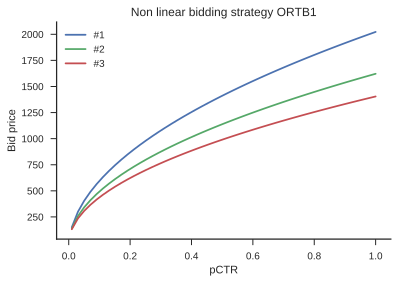

In [20]:
x = np.linspace(1e-2, 1)
y = ortb_strategy(0.000016,70,x)
y2 = ortb_strategy(0.000011,30,x)
y3 = ortb_strategy(0.000005,10,x)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy ORTB1')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


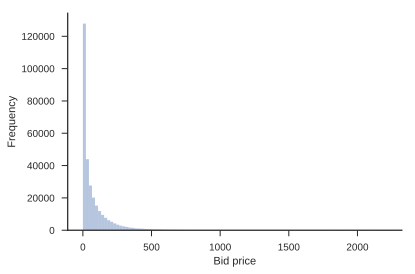

In [48]:
x = np.linspace(1e-2, 1)
y = ortb_strategy(0.000017,90,pCTR)

sns.distplot(y, kde=False, bins=100);
sns.despine()
plt.ylabel('Frequency')
plt.xlabel('Bid price')
plt.show()

## ORTB2

In [22]:
payprice = validation['payprice']
clicks = validation['click']

ortb_strategy2 = lambda lamda, const, pCTR: const * (((pCTR+np.sqrt(const**2*lamda**2 + pCTR**2))/(const*lamda))**(1/3)- ((const*lamda)/(pCTR+np.sqrt(const**2*lamda**2 + pCTR**2)))**(1/3))

lamda_range = np.linspace(1e-7, 1e-4, num=20)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

# find optimal parameters
for const, lamda in tqdm(parameter_grid):
    budget_remaining = 6250*1000
    
    index = (const, lamda)
    
    statistics[index] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0,
        'lost': 0
    }
    
    # list of bids for all ad requests
    bids = ortb_strategy2(lamda, const, pCTR)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[index]['too_expensive'] += 1
            
        if(second_highest_bid> bids[i]):
            statistics[index]['lost'] += 1
        
        
        if(won):
            statistics[index]['impressions'] += 1
            statistics[index]['spend'] += second_highest_bid
            statistics[index]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
    
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')

100%|██████████| 180/180 [17:53<00:00,  5.77s/it]

done


In [84]:
statistics.sort_values('clicks', ascending=False).head(15)

,,clicks,impressions,spend,too_expensive,CTR,aCPM,aCPC
90,0.000017,160,111670,6249998,207,0.001433,55.968461,39.062487
80,0.000016,160,112049,6250000,3241,0.001428,55.779168,39.062500
60,0.000014,160,113436,6250000,5568,0.001410,55.097147,39.062500
90,0.000018,159,108892,6043632,0,0.001460,55.501157,38.010264
20,0.000008,159,118278,6095202,0,0.001344,51.532846,38.334604
30,0.000010,159,117931,6243252,0,0.001348,52.939872,39.265736
70,0.000015,159,112677,6250000,4987,0.001411,55.468285,39.308176
50,0.000013,159,114672,6250000,3334,0.001387,54.503279,39.308176
10,0.000005,159,118957,5897030,0,0.001337,49.572787,37.088239
80,0.000017,159,110134,6091537,0,0.001444,55.310231,38.311553


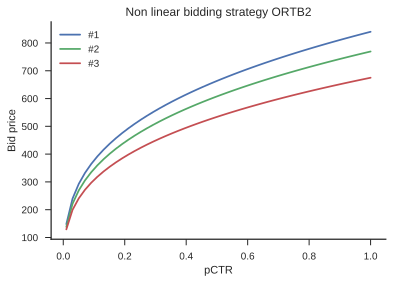

In [26]:
x = np.linspace(1e-2, 1)
y = ortb_strategy2(0.000021,80,x)
y2 = ortb_strategy2(0.000021,70,x)
y3 = ortb_strategy2(0.000016,50,x)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy ORTB2')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

## Alternative

In [27]:
payprice = validation['payprice']
clicks = validation['click']

B =6250*1000
T = len(payprice)


strategy3 = lambda B, T, l, pCTR: 2*pCTR*(((B*(l**2)))/T)**(1/3)

const_range = np.arange(10, 1000, 20)


statistics = {}

# find optimal base_bid
for l in tqdm(const_range):
    budget_remaining = 6250*1000
    
    statistics[l] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0,
        'lost': 0
    }
    
    # list of bids for all ad requests
    bids = strategy3(B, T, l, pCTR)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        # limit spend per impression
        if(bids[i] > 250):
            bids[i] = 250
            
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[l]['too_expensive'] += 1
            
        if(second_highest_bid > bids[i]):
            statistics[l]['lost'] += 1
        
        
        if(won):
            statistics[l]['impressions'] += 1
            statistics[l]['spend'] += second_highest_bid
            statistics[l]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
    
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')

100%|██████████| 50/50 [05:09<00:00,  6.21s/it]

done


In [28]:
statistics.sort_values('clicks', ascending=False).head(5)

,clicks,impressions,lost,spend,too_expensive,CTR,aCPM,aCPC
990,69,5251,298674,132910,0,0.013140,25.311369,1.926232
970,69,5158,298767,130549,0,0.013377,25.310004,1.892014
950,68,5074,298851,127825,0,0.013402,25.192156,1.879779
930,68,4996,298929,125619,0,0.013611,25.143915,1.847338
910,68,4916,299009,123530,0,0.013832,25.128153,1.816618


In [0]:
x = np.linspace(1e-2, 1)
y = strategy3(B, T, l, x)
y2 = strategy3(B, T, l, x)
y3 = strategy3(B, T, l, x)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy alternative form')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

# Use NN to predict pCTR on test and apply non-linear bidding strategy

In [0]:
batches = np.array_split(test, 200)

pCTR_test = []
for batch in batches:
    data = batch.drop(columns=['click', 'payprice']).values
    target = batch['click'].values
    
    data = torch.from_numpy(data).float()
    target = torch.from_numpy(target).float()
    
    output = model(data)
    
    prediction = (output.data).float()
    y_hat_prob = prediction.cpu().numpy().squeeze()
    
    pCTR_test.extend(y_hat_prob)
    
pCTR_test = np.array(pCTR_test)

In [0]:
X_test = test.drop(columns=['click', 'payprice'])

bids = bid_strategy(0.000016, 30, pCTR_test)

# get bid id's
test_raw = pd.read_csv(
    '/content/gdrive/My Drive/Colab Notebooks/we_data/test.csv')

# export to file
df_bids = pd.DataFrame(
    np.round(bids, 1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

file = '/content/gdrive/My Drive/Colab Notebooks/bid_attemnt_{}.csv'.format(
    time.strftime('%Y-%m-%d_%H:%M:%S'))
df_bids.to_csv(file, index=False)

# Multi agent strategy

In [0]:
def multi_agen_bid_function(pCTR):
    
    return np.sqrt(pCTR/3)*4000

    lamda = 0.000017
    const = 90
    number_of_items = len(pCTR)
    total_bids = []
    
    ortb_strategy = lambda lamda, const, pCTR: np.sqrt(np.multiply((const / lamda), pCTR) + const**2) - const
    
    for x in range(len(pCTR)):
        
        bid = ortb_strategy(lamda, const, pCTR[x])
        
        # do not bid for the first 20% of the items being sold
        if x < number_of_items*0.2:
            bid = 1
            
        # do not bid on items that are likely to be in very high demand
        if(pCTR[x] > 0.95):
            bid = 1
            
            
        if(pCTR[x] < 0.4):
            bid = bid*0.6
            
        # inflate bids that on items that are likely to be in lower demand
        if(pCTR[x] > 0.75 and pCTR[x] < 8.5):
            bid = bid*3
        
        # limit maxium bids
#         if(bid > 500):
#             bid = 500
            
            
        total_bids.append(bid)
        
        
    return total_bids
        

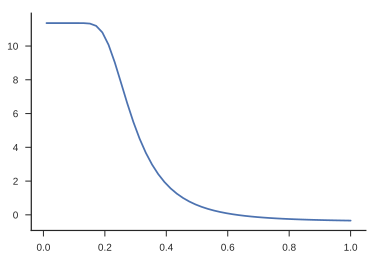

In [149]:
x = np.linspace(1e-2, 1)
y = multi_agen_bid_function(x)


plt.plot(x,y)
sns.despine()
plt.show()

In [143]:
budget_remaining = 6250*1000
    
statistics = {
    'impressions':0,
    'spend': 0,
    'clicks': 0,
    'too_expensive': 0,
    'lost': 0
}

# list of bids for all ad requests
bids = multi_agen_bid_function(pCTR)

# loop through all bids for every ad request
for i in range(len(bids)):    
    second_highest_bid = payprice[i]

    won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining

    if(second_highest_bid > budget_remaining):
        statistics['too_expensive'] += 1

    if(second_highest_bid> bids[i]):
        statistics['lost'] += 1


    if(won):
        statistics['impressions'] += 1
        statistics['spend'] += second_highest_bid
        statistics['clicks'] += clicks[i]

        # subtract current bid from budget 
        budget_remaining -= second_highest_bid


statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']

print(statistics)
print('done')

{'impressions': 34197, 'spend': 2260902, 'clicks': 122, 'too_expensive': 0, 'lost': 269728, 'CTR': 0.003567564406234465, 'aCPM': 66.11404509167471, 'aCPC': 18.53198360655738}
done


In [0]:
batches = np.array_split(test, 200)

pCTR_test = []
for batch in batches:
    data = batch.drop(columns=['click', 'payprice']).values
    target = batch['click'].values
    
    data = torch.from_numpy(data).float()
    target = torch.from_numpy(target).float()
    
    output = model(data)
    
    prediction = (output.data).float()
    y_hat_prob = prediction.cpu().numpy().squeeze()
    
    pCTR_test.extend(y_hat_prob)
    
pCTR_test = np.array(pCTR_test)

In [0]:
X_test = test.drop(columns=['click', 'payprice'])

bids = multi_agen_bid_function(pCTR_test)

# get bid id's
test_raw = pd.read_csv(
    '/content/gdrive/My Drive/Colab Notebooks/we_data/test.csv')

# export to file
df_bids = pd.DataFrame(
    np.round(bids, 1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

file = '/content/gdrive/My Drive/Colab Notebooks/bid_attemnt_multi_agent_strategy_{}.csv'.format(
    time.strftime('%Y-%m-%d_%H:%M:%S'))
df_bids.to_csv(file, index=False)